# Here we apply it first too all fibers (=B) in an IFU

# Todo


* Still woring only off the COSMOS repeats themselves.



In [57]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Next two lines force automatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
import os
import glob
from matplotlib import pyplot as plt
% matplotlib inline

from collections import OrderedDict
import spectrum



In [59]:
def load_skys(ff):
    skys = OrderedDict()
    shotids = []
    for f in ff:
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
        skys[(shotid,exp)] = rb["sky_spectrum"]/rb["fiber_to_fiber"] 

    print("starting wl = ", ww[0], "A")
    return ww, skys

In [60]:
IFU="022"

In [61]:
# Load the data
# how many PCA components do we want to maintain?
n_components = 20

ff_LL=glob.glob( "pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_LL_rebin.pickle".format(IFU) )
ff_LU=glob.glob( "pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_LU_rebin.pickle".format(IFU) )
ff_RL=glob.glob( "pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_RL_rebin.pickle".format(IFU) )
ff_RU=glob.glob( "pca_test/rebin/20??????v???/exp0?/multi_???_{}_???_RU_rebin.pickle".format(IFU) )

skys = OrderedDict()
ww,skys[(IFU,"LL")] = load_skys(ff_LL)
ww,skys[(IFU,"LU")] = load_skys(ff_LU)
ww,skys[(IFU,"RL")] = load_skys(ff_RL)
ww,skys[(IFU,"RU")] = load_skys(ff_RU)


shotids = [k for k in skys[(IFU,"LL")] ]

/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


starting wl =  3494.74 A
starting wl =  3494.74 A
starting wl =  3494.74 A
starting wl =  3494.74 A


In [72]:
fn_shotlist_pca = "shotlist_pca.txt"
fn_shotlist_skyrecon = "shotlist_skyrecon.txt"

with open(fn_shotlist_pca, 'r') as f:
    s = f.read()
shotlist_PCA = s.split()

with open(fn_shotlist_skyrecon, 'r') as f:
    s = f.read()
shotlist_skyrecon = s.split()

In [78]:
### FROM PCA_SKY5 for testing

# load rebinned data

def load_skys(ff, which="sky_spectrum", normalize=False):
    """
    Loads bunch of spectra (2D) from set of input file names.
    """
    skys = OrderedDict()
    shotids = OrderedDict()
    N = len(ff)
    sff = []
    for i,f in enumerate(ff):
        if i % 100 == 0:
            print("loading {} out of {}.".format(i,N))
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        try:
            ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
            skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"] 
            shotids[(shotid,exp)] = f
        except:
            print("Error loading {}.".format(f))
            pass
        
        if normalize:
            # NEW try to normalize by mean
            skys[(shotid,exp)][np.isnan(skys[(shotid,exp)])] = 0.
            skys[(shotid,exp)] = (skys[(shotid,exp)].T /np.mean( skys[(shotid,exp)], axis=1 )).T
    print("start wl = ", ww[0], "A", "end wl = ", ww[-1], "A")
    return ww, skys, sff



def load_skys_for_shotlist(IFU, shotlist, amps):
    # load all skys for given list of shots
    # this newer version makes sure that there is always date for all four amplifieres
    ff = OrderedDict()
    for amp in amps:
        ff[amp] = []
    exposures = ['exp01','exp02','exp03']
    for shot in shotlist:
        if shot.startswith("#"):
            continue
        for e in exposures:
            pattern = "{}/{}/{}/multi_???_{}_???_{}_rebin.pickle".format(dir_rebin, shot, e,IFU, "??")
            fff = np.sort(glob.glob(pattern))
            if len( fff ) == 4:
                ff['LL'] += [fff[0]]
                ff['LU'] += [fff[1]]
                ff['RL'] += [fff[2]]
                ff['RU'] += [fff[3]]
            else:
                print("WARNING: for {} exp {}, not all four amps have data, dropping ....".format(shot, e))
    skys = OrderedDict()
    for amp in amps:
        ww,skys[(IFU,amp)],sff = load_skys(ff[amp],which="sky_spectrum")

    return ww,skys

amps = ["LL", "LU", "RL", "RU"]
IFU="022"
dir_rebin="pca_test/rebin"
# selct wavelength subrange
wstart = 3495.
#wend = 5493.
wend = 5454.76 # masking out one bad feature at the red end

ww, skys = load_skys_for_shotlist(IFU, shotlist_PCA, amps)

_shotids = [k for k in skys[(IFU,"LL")] ]



loading 0 out of 366.


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


loading 100 out of 366.
loading 200 out of 366.
loading 300 out of 366.
start wl =  3494.74 A end wl =  5498.4523582 A
loading 0 out of 366.
loading 100 out of 366.
loading 200 out of 366.
loading 300 out of 366.
start wl =  3494.74 A end wl =  5496.4665184 A
loading 0 out of 366.
loading 100 out of 366.
loading 200 out of 366.
loading 300 out of 366.
start wl =  3494.74 A end wl =  5492.494838799999 A
loading 0 out of 366.
loading 100 out of 366.
loading 200 out of 366.
loading 300 out of 366.
start wl =  3494.74 A end wl =  5498.4523582 A


In [111]:
# Select referece source
#skys[("022","LL")] = skys

#for f in skys[("022","LL")]:
#    print(f)

if False:
    # we will use the information in fiber A (here fiber 50 in 022,LL), to ...
    fiber = 50
    XA = np.array( [skys[(IFU,"LL")][k][fiber] for k in skys[(IFU,"LL")] ] )

if False:
    # we will use the information in fiber A (here fiber 50 in 022,LU), to ...
    fiber = 50
    XA = np.array( [skys[(IFU,"LU")][k][fiber] for k in skys[(IFU,"LU")] ] )

if False:
    # we will use the information in fiber A (here beiweight location (~ mean) in 022, LU), so from a different amplifier ,to ...
    #XA = np.array( [ biweight_location( skys[("022","LU")][k], axis=0 )  for k in skys[("022","LU")] ] )
    # we will use the information in fiber A (here beiweight location (~ mean) in 022, RU), so from a different spectrograph, to ...
    XA = np.array( [ biweight_location( skys[(IFU,"RU")][k], axis=0 )  for k in skys[(IFU,"RU")] ] )

if False:
    # here we will use as A  the beiweight location (~ mean) in 022, RU), so from a different IFU, to ...
    # this does not work well, fundametally also a question of focal plane illumination I think
    XA = np.array( [ biweight_location( skys[("105","RU")][k], axis=0 )  for k in skys[("105","RU")] ] )

if True:
    # here we will use as A  the beiweight location (~ mean) from the entire IFU 
    XA = []
    for k in skys[(IFU,"LU")]:
        if k in skys[(IFU,"LU")] and k in skys[(IFU,"LL")] and k in skys[(IFU,"RU")] and k in skys[(IFU,"RL")]:
            LU = skys[(IFU,"LU")][k]
            LL = skys[(IFU,"LL")][k]
            RU = skys[(IFU,"RU")][k]
            RL = skys[(IFU,"RL")][k]
            stack = np.vstack([LU,LL,RU,RL]) 
            bloc = biweight_location( stack, axis=0) 
            XA.append(bloc)
    XA = np.array(XA)



# hack to homogenize lengths, the rebinning does make sure
# that the wavelength grid always stars at the same wavelength
# but not necessarey, end at the same ( ther may be a few pixel more or less)
#N = np.min([XA.shape[1], XB.shape[2], ww.shape[0]])
N = np.min([XA.shape[1], ww.shape[0]])
ww = ww[:N]
XA = XA[:,:N]


# can't have nans
XA[np.isnan(XA)] = 0.


# selct wavelength subrange
wstart = 4626.668686
#wend  = 4723.9748362
#wstart = 4626.668686
wend  = 5400.
wstart = 3500.
wstart = 3495.
wend = 5493.

#ww = 
ii = (ww >= wstart) * (ww <= wend)

wwcut = ww[ii]
_XAcut = XA[:,ii]

/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 4 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/astropy/stats/biweight.py:112: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 5 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 26 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 25 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/an

303 of 366 survive cut.


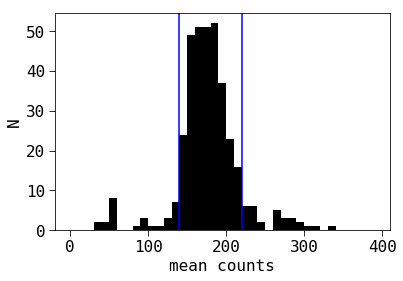

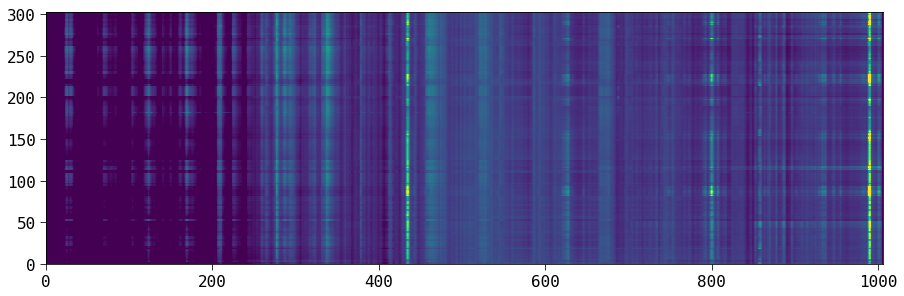

In [112]:
mm = np.mean( _XAcut[:,450:600], axis=1)

start, stop = 140., 220.
jj = (mm > start) * (mm < stop)
print("{} of {} survive cut.".format(np.sum(jj),len(jj)))

if True:
    plt.hist(mm,bins=np.arange(0,400,10))
    plt.axvline(start,c='b')
    plt.axvline(stop,c='b')
    plt.xlabel("mean counts")
    plt.ylabel("N")

    #% matplotlib notebook
    f = plt.figure(figsize=[15,15])
    #plt.imshow((XAcut.T/mm).T[jj*kk][:,275:300], vmin=.6,vmax=1.4, origin="bottom")
    plt.imshow((XAcut.T/mm).T[jj], vmin=.6,vmax=2.4, origin="bottom")
    
kk = jj


valid_shots = kk*jj


shotids = np.array(_shotids)[valid_shots]

In [114]:
XAcut = _XAcut[valid_shots]

In [115]:
MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

[10220.28614742  5938.70660167  3225.57600156  1383.89337769
   667.20256393   588.76906119   521.13527438   374.20839182
   305.25015786   263.28783872   240.08311434   187.1188987
   173.78932403   133.61927014   114.88296399   112.02452514
    92.26357652    89.18552866    69.87866524    63.94297331]


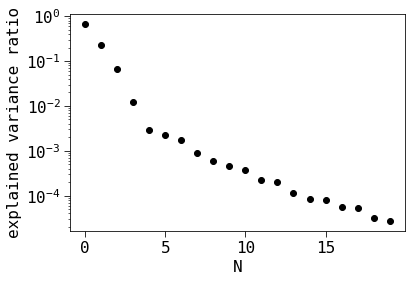

In [116]:
pcaA = PCA(n_components=n_components)
pcaA.fit(XAmean)
plt.plot(pcaA.explained_variance_ratio_, 'o')  
plt.xlabel("N")
plt.ylabel("explained variance ratio")
plt.yscale('log')
print(pcaA.singular_values_) 

In [117]:
# project pca componets onto
# mean shifted input spectra
ccA = np.inner(XAmean,pcaA.components_)

# reconstruct pca comonents through linear combination
rcA = np.matmul( XAmean.T, ccA).T
# they wont be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

#rc = rc/np.linalg.norm(rc,axis=1)

In [118]:
# make sure the result is the same
if not (np.abs( rcA - pcaA.components_) < 1e-6).all():
    print("ERRO: Recontructed PCA components are not (almost) identical to the original ones.")
else:
    print("Reconstructed PCAs look good.")

ERRO: Recontructed PCA components are not (almost) identical to the original ones.


In [119]:
# compute projection of input spectra onto PCA basis
tA = pcaA.transform(XAmean)

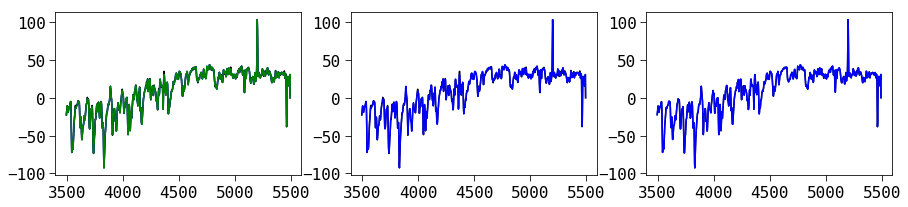

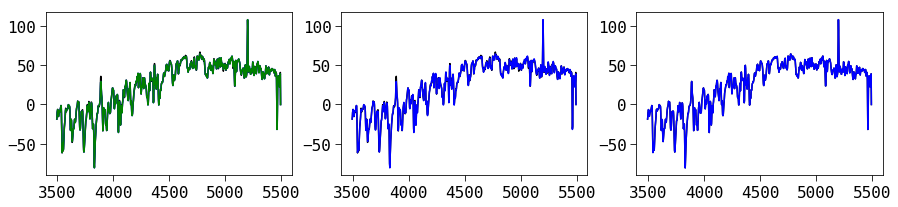

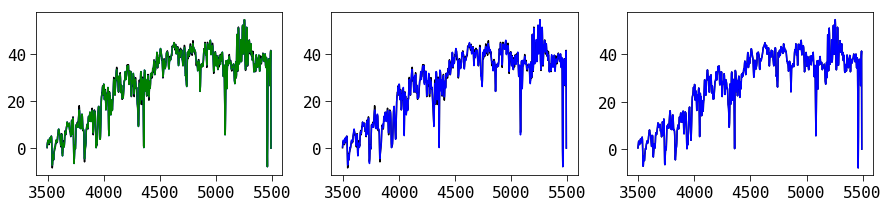

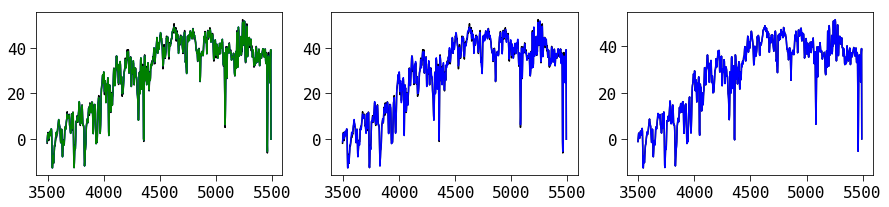

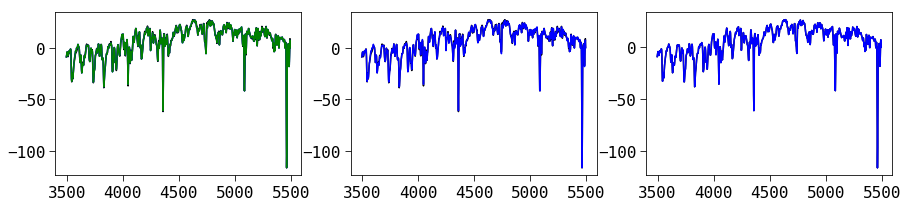

In [120]:
if True:
    # make sure we can reconstuct the spectra from the
    # actual principal components but also from the reconstructed ones
    for i in range(5):
        f = plt.figure(figsize=[15,3])
        plt.subplot(131)
        plt.plot(wwcut, XAmean[i] )
        plt.plot(wwcut,  np.inner(tA, pcaA.components_.T)[i] )
        plt.plot(wwcut,  pcaA.inverse_transform(tA)[i] )


        plt.subplot(132)
        plt.plot(wwcut,  XAmean[i] )
        plt.plot(wwcut,  np.inner(tA, rcA.T)[i] )


        plt.subplot(133)
        plt.plot(wwcut,  np.inner(tA, pcaA.components_.T)[i] )
        plt.plot(wwcut,  np.inner(tA, rcA.T)[i] )


# Now apply this to B

Wrote  pca_test/rebin/20180106v005/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180107v003/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180110v021/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180110v021/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180110v021/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v007/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v009/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v009/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v009/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v010/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v010/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v010/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180112v011/exp01/pca_multi_3

Wrote  pca_test/rebin/20180209v014/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180210v006/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180210v006/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180210v006/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180211v017/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180211v017/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180211v017/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180211v018/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180211v018/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180212v010/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180212v010/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180213v008/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180213v008/exp02/pca_multi_3

Wrote  pca_test/rebin/20180307v003/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180307v003/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180307v003/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180309v001/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180309v001/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180309v003/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180309v004/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180309v004/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180309v004/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180310v006/exp01/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180310v006/exp02/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180310v006/exp03/pca_multi_317_022_039_LU_rebin.pickle
Wrote  pca_test/rebin/20180310v007/exp01/pca_multi_3

Wrote  pca_test/rebin/20180112v012/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180112v012/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180112v012/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v006/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v010/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v010/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v010/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v011/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v011/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v012/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v012/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v012/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180113v013/exp01/pca_multi_3

Wrote  pca_test/rebin/20180213v008/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180213v008/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180213v011/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180213v011/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180213v011/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v004/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v005/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v005/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v005/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v006/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v006/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v006/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180215v007/exp01/pca_multi_3

Wrote  pca_test/rebin/20180311v009/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180311v009/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180311v009/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v006/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v006/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v006/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v009/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v009/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v009/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v010/exp01/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v010/exp02/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v010/exp03/pca_multi_317_022_039_LL_rebin.pickle
Wrote  pca_test/rebin/20180312v014/exp01/pca_multi_3

Wrote  pca_test/rebin/20180113v014/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180113v014/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180113v015/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v012/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v012/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v012/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v013/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v013/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v013/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v014/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v014/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180114v014/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180115v010/exp01/pca_multi_3

Wrote  pca_test/rebin/20180215v008/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v008/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v008/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v009/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v009/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v009/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v011/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v011/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v011/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v013/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v013/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v013/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180215v014/exp01/pca_multi_3

Wrote  pca_test/rebin/20180312v014/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v008/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v008/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v008/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v009/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v009/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v009/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v010/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v010/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v010/exp03/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v011/exp01/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v011/exp02/pca_multi_317_022_039_RU_rebin.pickle
Wrote  pca_test/rebin/20180313v011/exp03/pca_multi_3

Wrote  pca_test/rebin/20180115v010/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180115v010/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180115v010/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180115v011/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180115v011/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180115v011/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180115v012/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180115v012/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180119v016/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180119v016/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180119v016/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180120v008/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180120v008/exp02/pca_multi_3

Wrote  pca_test/rebin/20180215v014/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180215v015/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180215v015/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180215v015/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v009/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v009/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v009/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v010/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v010/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v010/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v012/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v012/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180216v012/exp03/pca_multi_3

Wrote  pca_test/rebin/20180313v013/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180313v013/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180313v013/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180313v016/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180313v016/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180313v016/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180316v007/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180316v007/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180316v007/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180316v008/exp01/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180316v008/exp02/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180316v008/exp03/pca_multi_317_022_039_RL_rebin.pickle
Wrote  pca_test/rebin/20180316v015/exp01/pca_multi_3

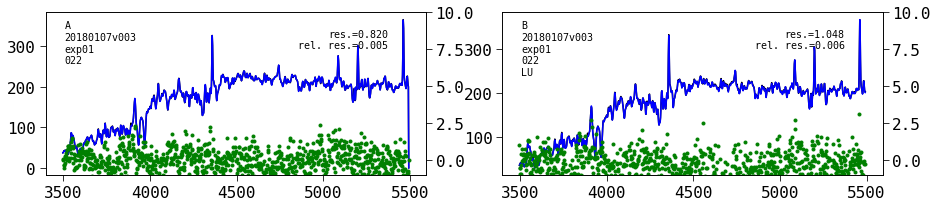

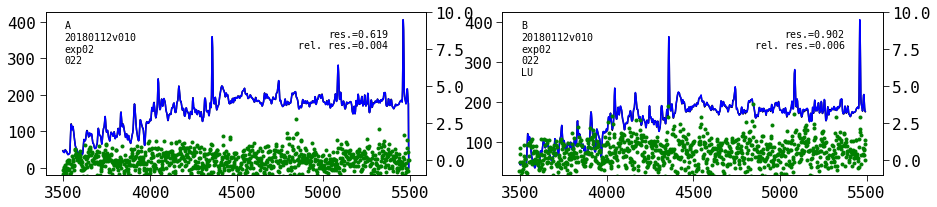

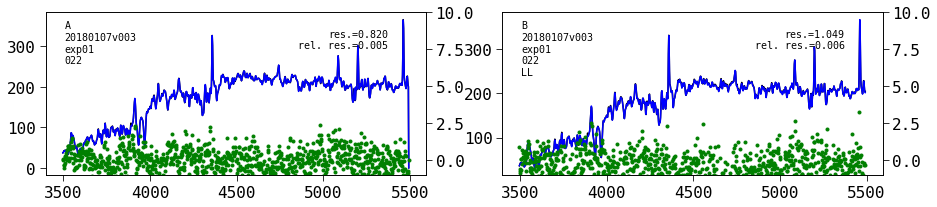

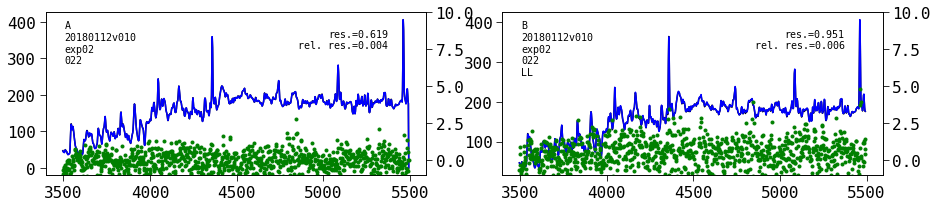

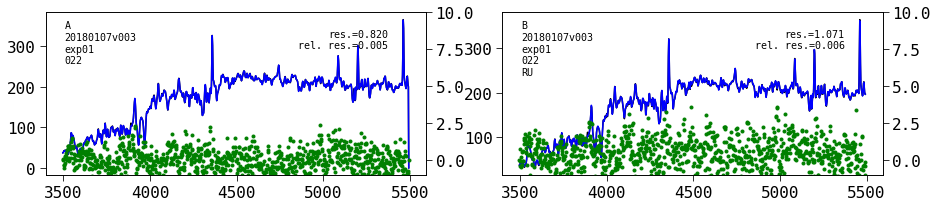

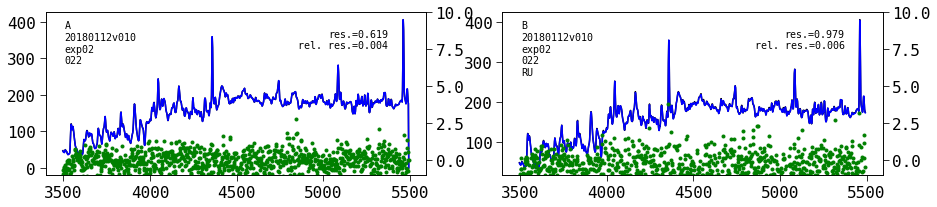

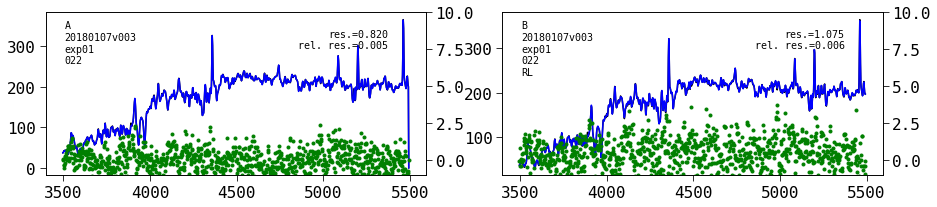

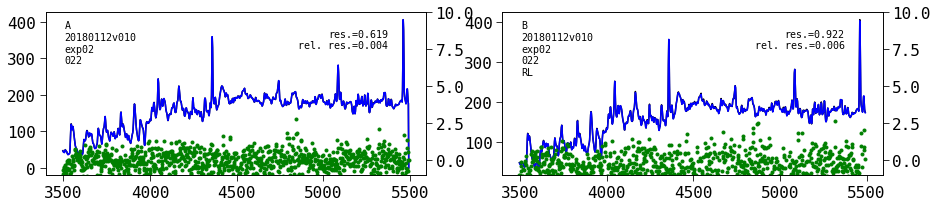

In [147]:
# load data


#XB = []
#for k in skys[(IFU,"LU")]:
#    LU = skys[(IFU,"LU")][k]
#    LL = skys[(IFU,"LL")][k]
#    RU = skys[(IFU,"RU")][k]
#    RL = skys[(IFU,"RL")][k]
#    stack = np.vstack([LU,LL,RU,RL])  
#    XB.append(stack)
#XB = np.array(XB)


for amp in ["LU", "LL", "RU", "RL"]:
#for amp in ["RU"]:
    B = (IFU,amp) # here we select, which IFU and amp we build the 
                     # PCA sky for
    # reconstruct the sky in fiber B, (here fiber 75 in 022,LL).
    # first dimension is shot, second is wavelength, third is fiber
    XB = np.array( [skys[B][k] for k in skys[B] ] )

    XB = XB[:,:,:N]
    XB[np.isnan(XB)] = 0.
    _XBcut = XB[:,:,ii]
    XBcut = _XBcut[valid_shots]

    MB = np.mean(XBcut,axis=0)
    XBmean = XBcut - MB



    if True:
        fiber = 50
        # Finally, chack how well we are doing:
        # Make sure we can reconstuct the spectra from the
        # actual principal components for A but also from the reconstructed ones for B
        for i in [1,10]:
            ## reconstruct pca components of B through linear combination of spectra from B
            ## BUT using projection from A
            rcB = np.matmul( XBmean[:,fiber,:].T, ccA).T
            # they wont be normalized yet
            for j,cB in enumerate(rcB):
                rcB[j] = rcB[j]/np.linalg.norm(rcB[j])
    
            f = plt.figure(figsize=[15,3])
            ax = plt.subplot(121)

            y  = XAmean[i] + MA
            ry = np.inner(tA, pcaA.components_.T)[i] + MA
            res = ry-y
            plt.plot(wwcut,  y )
            plt.plot(wwcut,   ry )
            plt.twinx()
            plt.plot(wwcut,   res, 'g.'  )
            plt.ylim([-1,10.])
            plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
            plt.text(0.05,0.95,"A\n{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  fiber ), transform = ax.transAxes, ha='left',va='top')
            ax = plt.subplot(122, sharex=ax)

            y  = XBmean[i,fiber,:] + MB[fiber,:]
            ry = np.inner(tA, rcB.T)[i] + MB[fiber,:]
            res = ry-y

            plt.plot(wwcut,   y )
            plt.plot(wwcut,   ry )
            plt.twinx()

            plt.plot(wwcut,   res, 'g.' )
            plt.ylim([-1,10.])
            plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
            plt.text(0.05,0.95,"B\n{}\n{}\n{}\n{}".format(shotids[i][0], shotids[i][1], B[0],  B[1], fiber ), transform = ax.transAxes, ha='left',va='top')
            
            

        #break
        
    # plot PCA components for A and B
    if False:
        for i in range(pcaA.n_components):
            f = plt.figure(figsize=[15,2])
            plt.subplot(121)
            #plt.plot( XAmean[i] )
            plt.plot( pcaA.components_[i] )
            plt.subplot(122)
            #plt.plot( Xmean[i] )
            plt.plot( rcB[i] )    

    if False:
        B_recon_sky = np.zeros_like(XBmean)
        i = 0 # select shot
        for fiber in range(XBmean.shape[1]):
            #print(fiber)
            # reconstruct pca components of B through linear combination of spectra from B
            # BUT using projection from A
            rcB = np.matmul( XBmean[:,fiber,:].T, ccA).T
            # they wont be normalized yet
            for j,cB in enumerate(rcB):
                rcB[j] = rcB[j]/np.linalg.norm(rcB[j])

            ry = np.inner(tA, rcB.T)[i] + MB[fiber,:]
            B_recon_sky[i,fiber,:] = ry


            y  = XBmean[i,fiber,:] + MB[fiber,:]
            res = ry-y

            if False:
                f = plt.figure(figsize=[15,3])
                ax = plt.subplot(122, sharex=ax)
                plt.plot(wwcut,   y )
                plt.plot(wwcut,   ry )
                plt.twinx()

                plt.plot(wwcut,   res, 'g.' )
                plt.ylim([-1,10.])
                plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')

    # Attempt for a faster version, does unfortunately NOT give the same results
    if False:
        B_recon_skyNew = np.zeros_like(XBmean)
        i = 1 # select shot

        rcB = np.matmul( XBmean[:,:,:].T, ccA).T
        # they wont be normalized yet
        for j,cB in enumerate(rcB):
            rcB[j] = ( rcB[j].T/np.linalg.norm(rcB[j], axis=1) ).T

        ry = (np.inner(tA, rcB.T)[i].T + MB[fiber,:].T)
        B_recon_skyNew[i,:,:] = ry

        f=plt.figure()
        plt.imshow( B_recon_skyNew[i] )

        f=plt.figure()
        plt.imshow( B_recon_sky[i] )

        f=plt.figure()
        plt.imshow( B_recon_sky[i] - B_recon_skyNew[i] )

    if False:
        i = 0
        f = plt.figure(figsize=[30,15])
        ax1 = plt.subplot(311)
        im = plt.imshow( B_recon_sky[i,:,:] )
        cbar = f.colorbar(im)

        ax1 = plt.subplot(312)
        im = plt.imshow( XBmean[i,:,:] + MB[:,:]  )
        cbar = f.colorbar(im)

        ax1 = plt.subplot(313)
        res = (B_recon_sky[i,:,:]  - (XBmean[i,:,:] + MB[:,:] ) )
        im = plt.imshow( res/MB[:,:] )

        cbar = f.colorbar(im)

        print(i)


    # Now do it for all nights
    B_recon_sky = np.zeros_like(XBmean)

    for i in range(XBmean.shape[0]):
        for fiber in range(XBmean.shape[1]):
            #print(fiber)
            # reconstruct pca components of B through linear combination of spectra from B
            # BUT using projection from A
            rcB = np.matmul( XBmean[:,fiber,:].T, ccA).T
            # they wont be normalized yet
            for j,cB in enumerate(rcB):
                rcB[j] = rcB[j]/np.linalg.norm(rcB[j])
            
            B_recon_sky[i,fiber,:] = np.inner(tA, rcB.T)[i] + MB[fiber,:]


    def save_sky(IFU, amp , k, pca_sky):
        pattern="pca_test/rebin/{}/{}/multi_???_{}_???_{}_rebin.pickle"
        shotid, exp = k

        _pattern = pattern.format(shotid, exp, IFU, amp)
        ff = glob.glob(_pattern)
        if not len(ff) == 1:
            print("ERROR: Did not find files like {}".format(_pattern))
            return
        fname = ff[0]

        h,t = os.path.split(fname)
        pca_fname = os.path.join(h,"pca_" + t)

        ww,rb = pickle.load( open(fname,'rb'), encoding='iso-8859-1' )
        #rb["fiber_to_fiber"] = rb["fiber_to_fiber"][:,:N]
        rb["pca_sky_spectrum"] = rb["sky_spectrum"].copy()
        rb["pca_sky_spectrum"][:,:N][:,ii] = pca_sky * rb["fiber_to_fiber"][:,:N][:,ii] 
        
        
        rb['sky_subtracted'] = rb['sky_subtracted'] + rb['sky_spectrum'] - rb['pca_sky_spectrum']

        pickle.dump(  ( ww,rb), open(pca_fname,'wb') , protocol=2   )
        print("Wrote ", pca_fname)
        

        
    for i,k in enumerate(shotids):

        save_sky(IFU, amp , k, B_recon_sky[i])



    #save_skys(B, pca_sky, pattern)

pca_test/rebin/20180313v013/exp01/pca_multi_317_022_039_RL_rebin.pickle


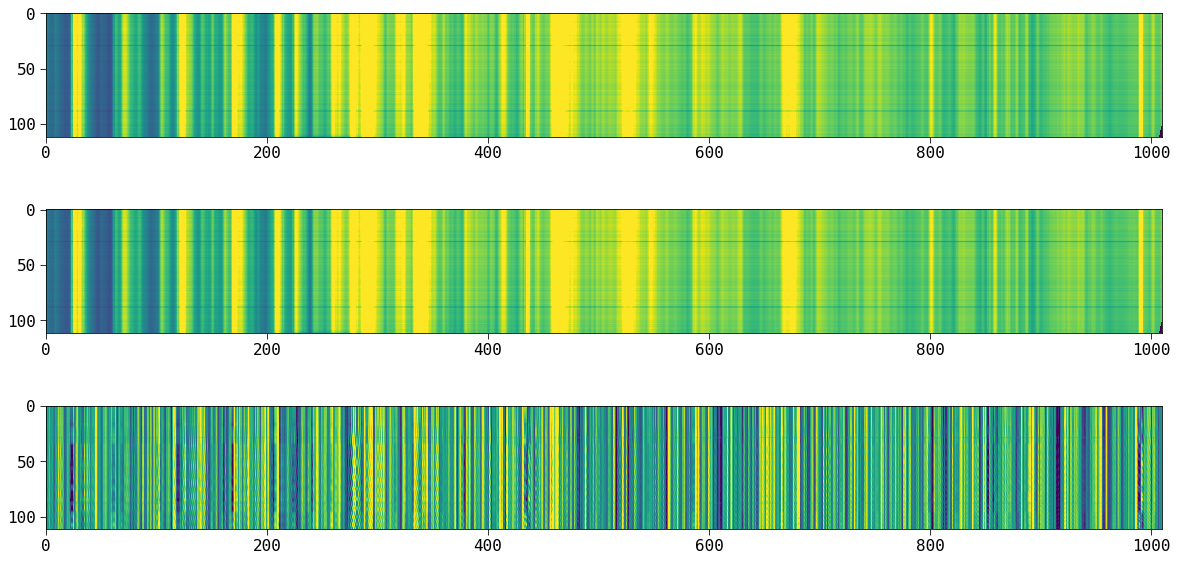

In [154]:
#fn = "pca_test/rebin/20180209v009/exp03/pca_multi_316_032_052_LL_rebin.pickle"
ff = glob.glob("pca_test/rebin/20180313v013/exp01/pca_multi_317_022_039_RL_rebin.pickle".format(IFU))
fn = ff[0]
print(fn)
ww,rb = pickle.load(open(fn, 'rb'))


f = plt.figure(figsize=[20,10])
#f = plt.figure()
plt.subplot(311)
plt.imshow( rb['sky_spectrum'] , vmax=200.)
plt.subplot(312)
plt.imshow( rb['pca_sky_spectrum'] , vmax=200.)
plt.subplot(313)
plt.imshow( rb['sky_spectrum'] - rb['pca_sky_spectrum'], vmin=-2., vmax=2. )

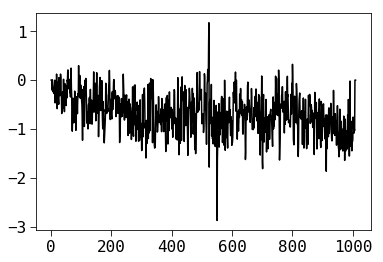

In [152]:
plt.plot( (rb['sky_spectrum'] - rb['pca_sky_spectrum'])[75,:] )  

pca_test/rebin/20180123v009/exp01/pca_multi_???_022_???_LU_rebin.pickle
pca_test/rebin/20180123v009/exp01/pca_multi_317_022_039_LU_rebin.pickle


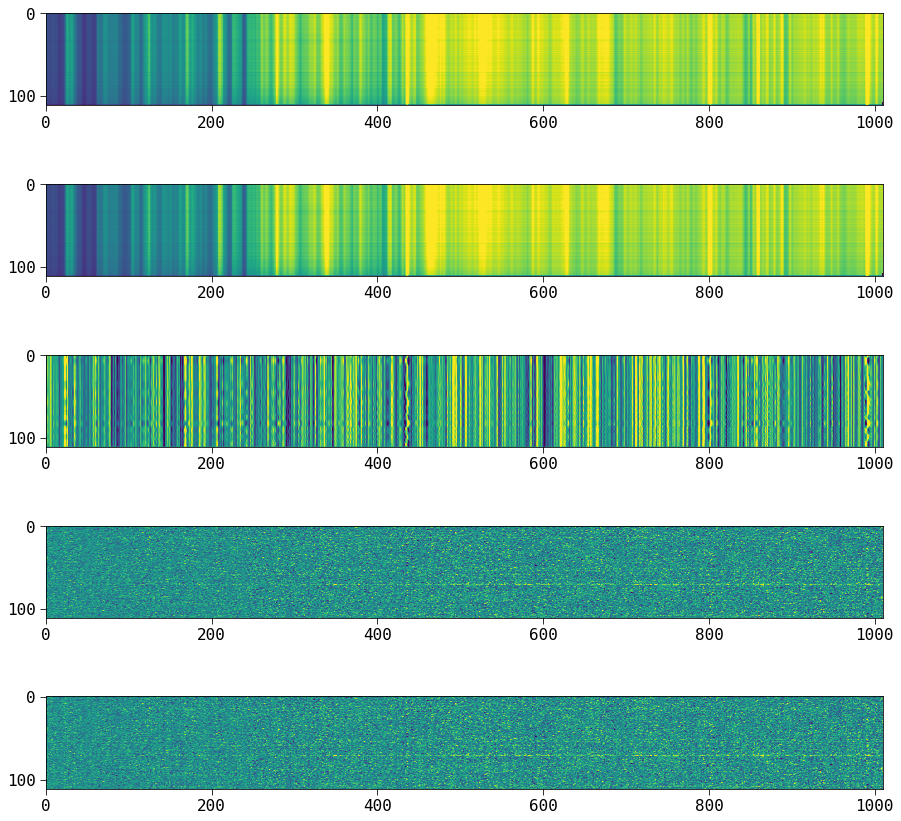

In [153]:
for k in  [("20180123v009","exp01")]:
    for amp in ["LU", "LL", "RU", "RL"]:
        shotid, exp = k
        pattern = "pca_test/rebin/{}/{}/pca_multi_???_{}_???_{}_rebin.pickle".format(shotid, exp, IFU, amp)
        print(pattern)
        ff = glob.glob(pattern)
        print(ff[0])
        
        
        ww,rb = pickle.load(open(ff[0], 'rb'))

        f = plt.figure(figsize=[15,15])
        plt.subplot(511)
        plt.imshow( rb['sky_spectrum'] , vmax=200.)
        plt.subplot(512)
        plt.imshow( rb['pca_sky_spectrum'] , vmax=200.)
        plt.subplot(513)
        plt.imshow( rb['sky_spectrum'] - rb['pca_sky_spectrum'], vmin=-2., vmax=2. )
        
        plt.subplot(514)
        plt.imshow( rb['sky_subtracted'], vmin=-50., vmax=50. ) 
        plt.subplot(515)
        plt.imshow( rb['sky_subtracted'] + rb['sky_spectrum'] - rb['pca_sky_spectrum'] , vmin=-50., vmax=50. )
        break
    break

In [ ]:
ff